# Example `genbed` workflow

This notebook shows a typical workflow, using an example dataset from `scikit-learn`.

-----

### Preamble

Here, we simply import everything and tweak a few key notebook settings.

In [1]:
# Make sure we are able to load `genbed` itself

#import os
#print(os.getcwd())

import sys
sys.path.insert(0, '../')

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn, sklearn.datasets, sklearn.model_selection

import genbed.classification as gclass
import genbed.statistics as gstats
import genbed.visualisation as gvis

In [3]:
# Set up figure plotting parameters
%matplotlib inline
# https://stackoverflow.com/a/50812446
#mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['figure.dpi'] = 200.0
sns.set_context(
    'paper', font_scale=1.0,
    rc={
        #'figure.figsize': (12.0, 8.0),
        'figure.dpi': 200.0
    }
)

In [4]:
# Record key info about environment
%load_ext watermark
%watermark --date --time --timezone --watermark --machine --python --iversion --githash --author "Sam Harrison"

Author: Sam Harrison

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: b7033600d411b0c46f5664fa5bfc3b96e42d39bf

genbed    : 0.1.0-dev
sklearn   : 0.23.2
pandas    : 1.2.2
sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.19.2

Watermark: 2.2.0



-----

### Raw data

The data we use here is the 'wine dataset', and we simply use the data bundled with [`scikit-learn`](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset):
> The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

In [5]:
raw_data = sklearn.datasets.load_wine()
print(raw_data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

-----

### Conversion to pandas format

Internally, `genbed` uses pandas DataFrames to manage data. This has the distinct advantage that it is easier to keep track of different features or observations, as they have explicit names. We **strongly** recommend that features, observations, and classes are all given descriptive names!

In [6]:
data = pd.DataFrame(raw_data['data'], columns=raw_data['feature_names'])
data.index = ["wine-{:03d}".format(i) for i in data.index]

labels = pd.Series(raw_data['target'], dtype='category').cat.rename_categories(raw_data['target_names'])
labels.index = data.index

-----

### Deconfounding

To illustrate the linear deconfounding approach, we arbitrarily take a handful of features as confounds. These can be passed to nearly all `genbed` functions.

In [7]:
confound_list = ['hue', 'color_intensity']
full_data = data

confounds = data[confound_list]
data = data.drop(columns=confound_list)

-----

### Data exploration

We can use `genbed.visualisation` to look at the data in several ways, and this is a good place to start before running any classifications.

A quick visualisation of the original data shows that it is indeed likely to be easy to classify:

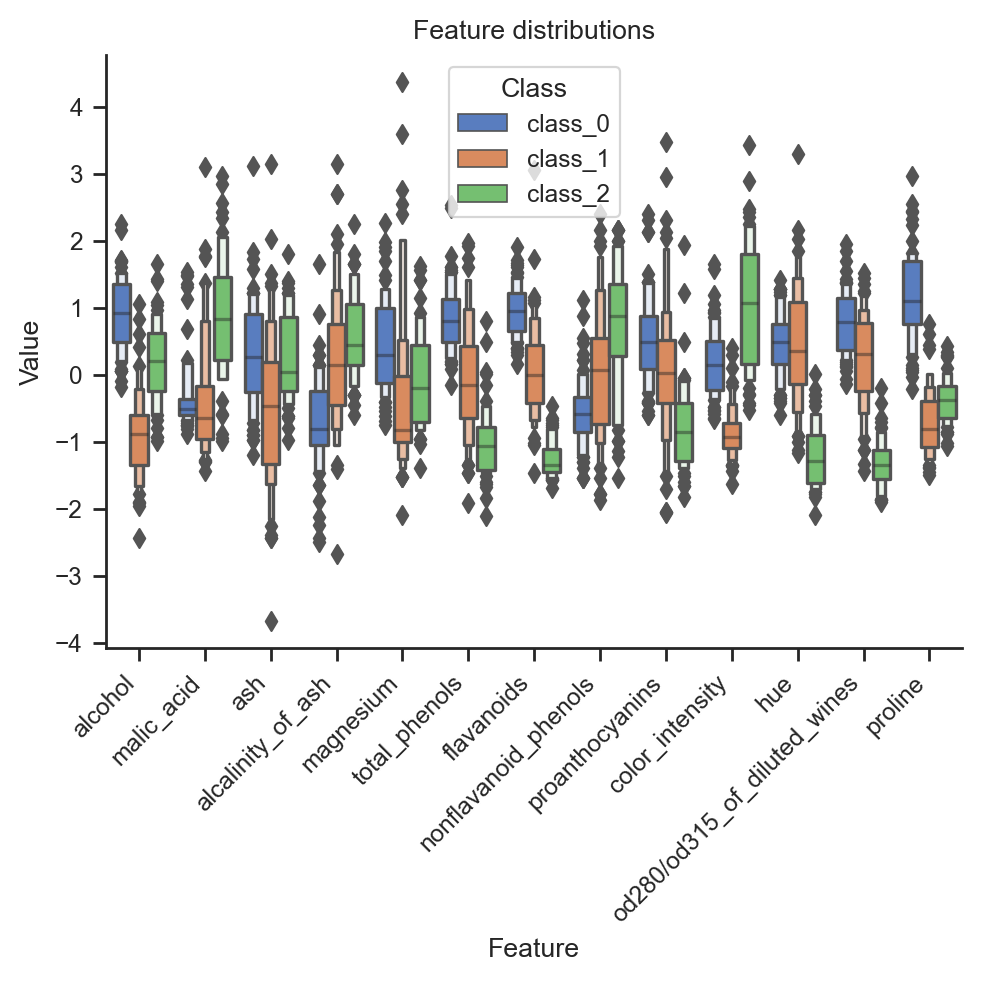

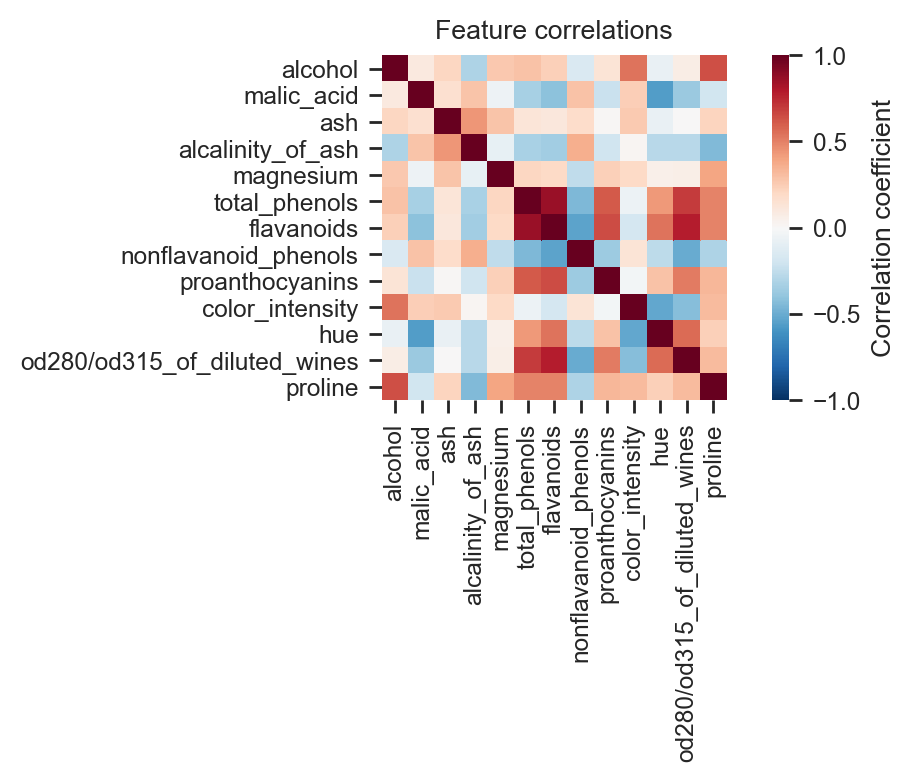

In [8]:
gvis.visualise_data(full_data, labels)

A quick visualisation of the deconfounded data shows it is now likely to be somewhat harder to classify the different wines.

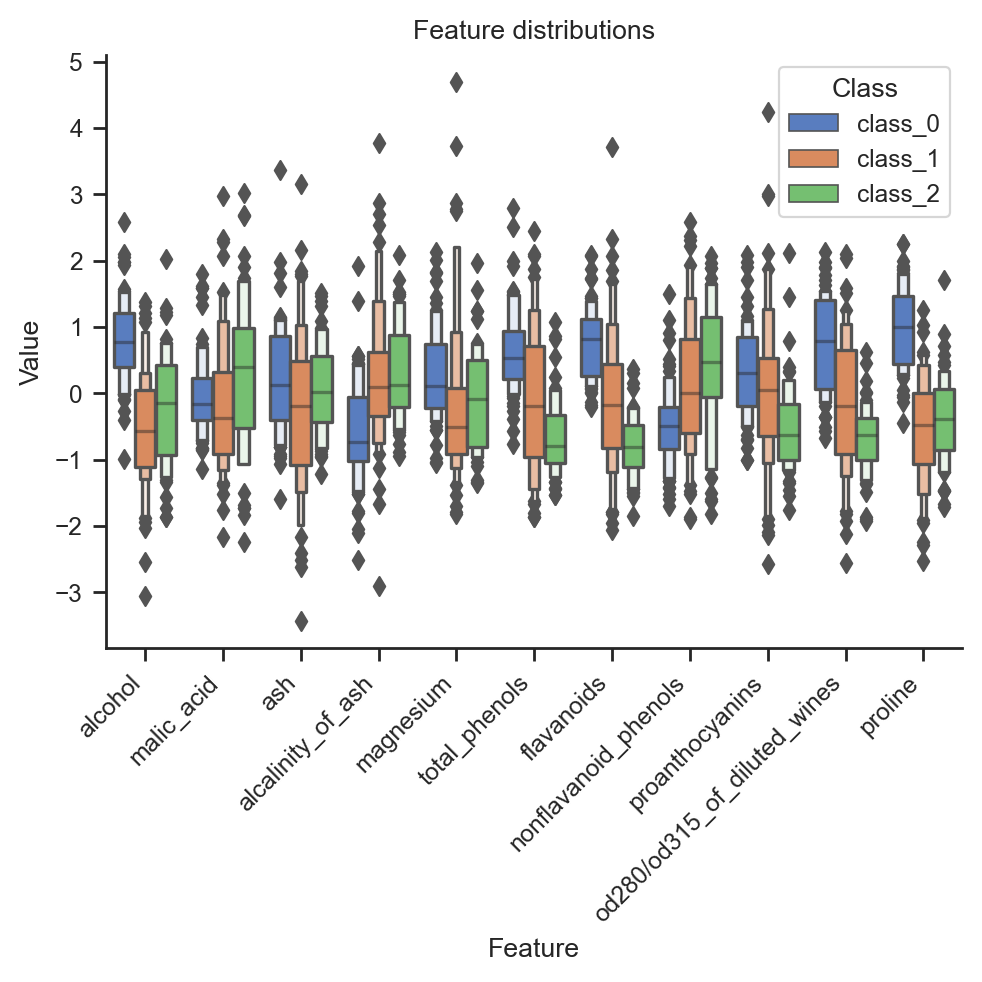

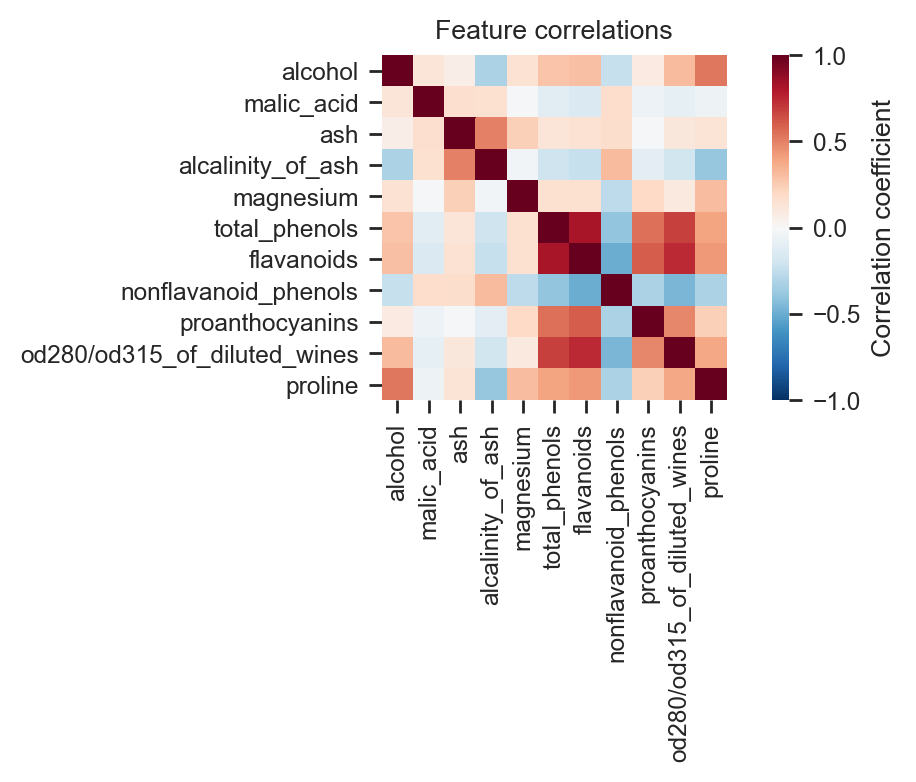

In [9]:
gvis.visualise_data(data, labels, confounds=confounds)

We can also visualise the data in a lower dimensional embedding space. While the classifier will use the data differently, this suggests `class_0` at least should be straightforwardly identifiable.

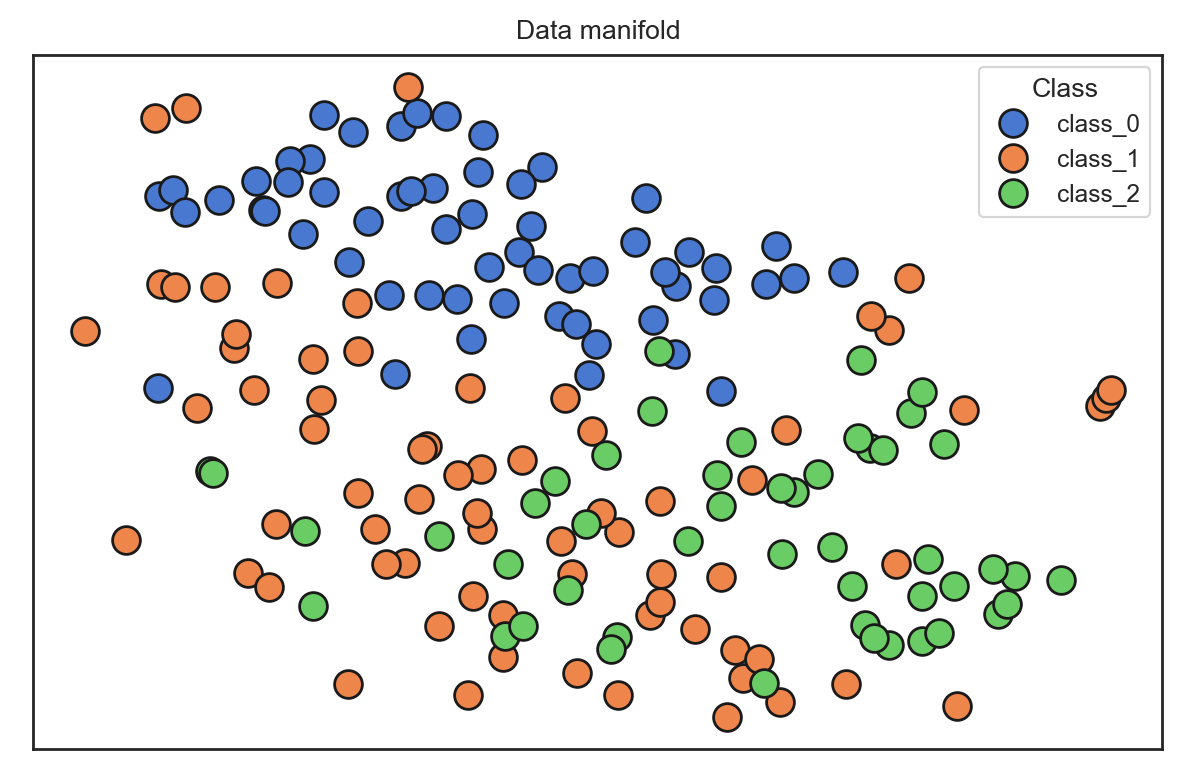

In [10]:
gvis.visualise_manifold(data, labels, confounds=confounds)

Finally, we can also run some descriptive statistics:

In [11]:
gstats.run_tests(data, labels, confounds=confounds)

Running statistical tests...
Correction for multiple comparisons is across features, not tests.
No. of features: 11
No. of observations: 178
No. of confounds: 2
No. of classes: 3
Classes: class_0, class_1, class_2

Class: class_0
No. of observations: 59
Shapiro-Wilk test for non-normality:
                      malic_acid: +0.90 [p=0.00]

Class: class_1
No. of observations: 71
Shapiro-Wilk test for non-normality:
                      malic_acid: +0.93 [p=0.01]
               alcalinity_of_ash: +0.94 [p=0.02]
                       magnesium: +0.81 [p=0.00]

Class: class_2
No. of observations: 48
Shapiro-Wilk test for non-normality:
                 proanthocyanins: +0.92 [p=0.03]

Kruskal-Wallis H-test for difference in group medians:
                         alcohol: +64.03 [p=0.00]
                      malic_acid: +9.31 [p=0.02]
               alcalinity_of_ash: +32.31 [p=0.00]
                       magnesium: +19.29 [p=0.00]
                   total_phenols: +49.89 [p=0.00]
     

-----

### Classification

Using the default approach (logistic regression), we get the following performance:

In [12]:
classifier, parameters = gclass.get_default_classifier()
predictions, probabilities = gclass.predict(
    data, labels, classifier, parameters,
    confounds=confounds, return_probabilities=True
)
gclass.evaluate_performance(labels, predictions)

Classifying data...
No. of features: 11
No. of observations: 178
No. of confounds: 2
No. of classes: 3
Classes: class_0, class_1, class_2

Finished iteration 1 of 10
{'clf__C': 0.01}
Finished iteration 2 of 10
{'clf__C': 1.0}
Finished iteration 3 of 10
{'clf__C': 1.0}
Finished iteration 4 of 10
{'clf__C': 0.01}
Finished iteration 5 of 10
{'clf__C': 100.0}
Finished iteration 6 of 10
{'clf__C': 0.01}
Finished iteration 7 of 10
{'clf__C': 0.01}
Finished iteration 8 of 10
{'clf__C': 0.01}
Finished iteration 9 of 10
{'clf__C': 0.01}
Finished iteration 10 of 10
{'clf__C': 0.1}

Evaluating classification performance...
No. of predictions: 178
No. of unique observations: 178
No. of classes: 3
Classes: class_0, class_1, class_2
N.B. metrics are calculated over all predictions, not within folds.

Balanced accuracy: 70.8%
Null: 33.3%

              precision    recall  f1-score   support

     class_0       0.80      0.97      0.88        59
     class_1       0.71      0.45      0.55        71
 

Again, we can also visualise this output. In the lower panel, we plot the class probabilities output by the logistic regression. The classifier is often correct if we assign the maximum probability label, but there is still considerable uncertainty about some of the predictions.

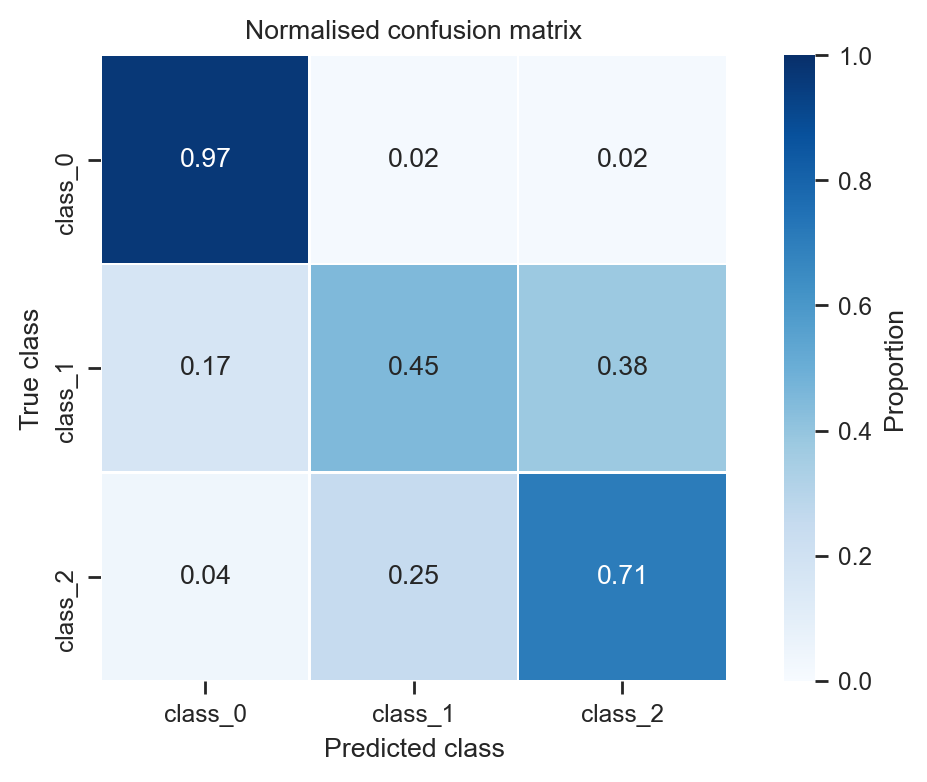

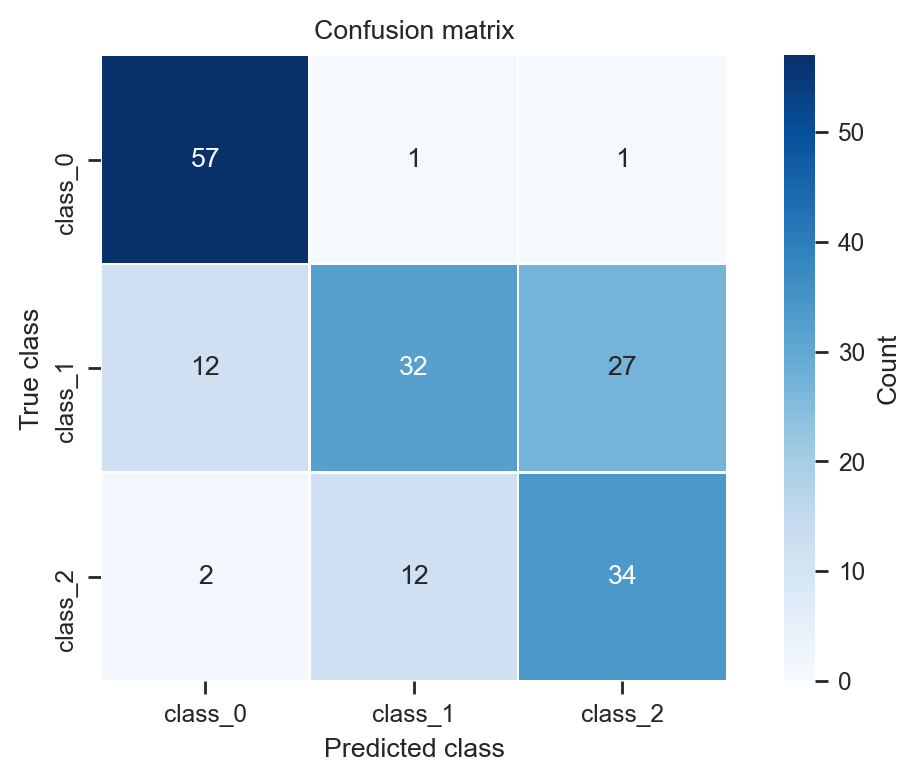

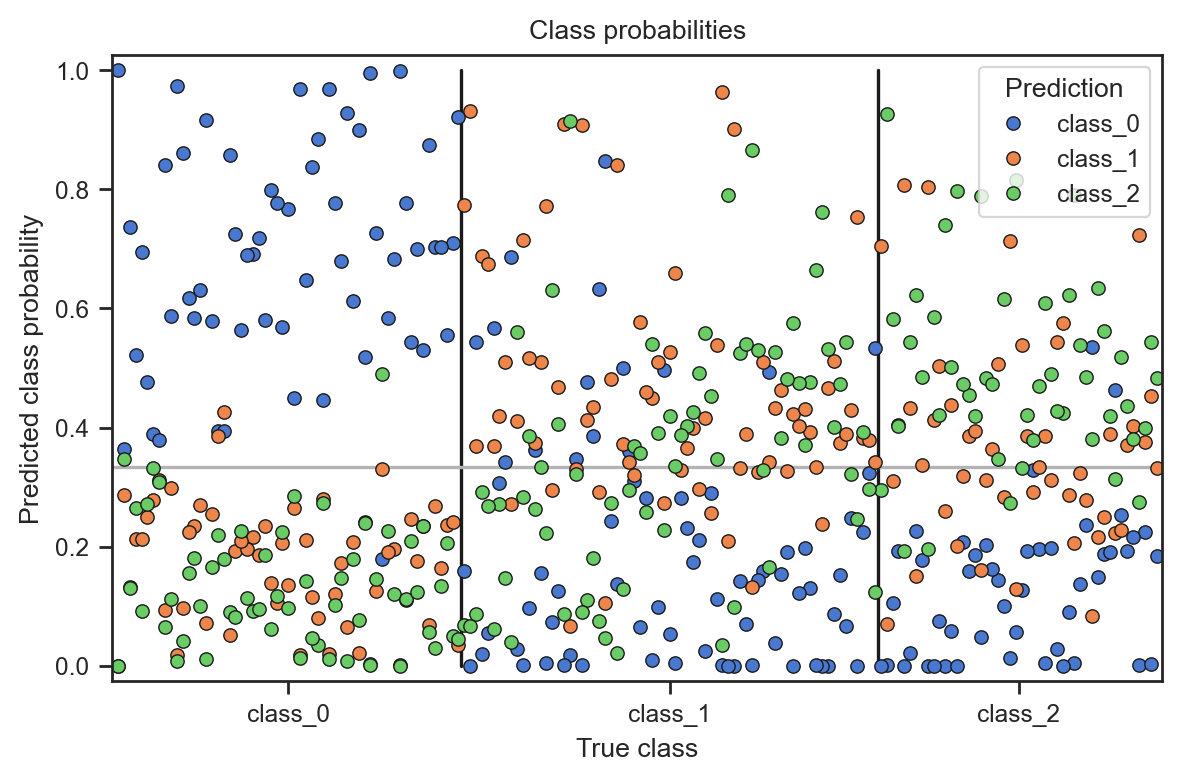

In [13]:
gvis.visualise_performance(labels, predictions, probabilities)

### Significance testing

We also want to know if this performance could have been achieved by chance. To do this, we use permutation testing. We use a very small number of permutations here to keep the runtime down (note the large confidence interval on the p-value!).

Building null distributions for classifier performance...
Finished permutation 0 of 25
Finished permutation 1 of 25
Finished permutation 2 of 25
Finished permutation 3 of 25
Finished permutation 4 of 25
Finished permutation 5 of 25
Finished permutation 6 of 25
Finished permutation 7 of 25
Finished permutation 8 of 25
Finished permutation 9 of 25
Finished permutation 10 of 25
Finished permutation 11 of 25
Finished permutation 12 of 25
Finished permutation 13 of 25
Finished permutation 14 of 25
Finished permutation 15 of 25
Finished permutation 16 of 25
Finished permutation 17 of 25
Finished permutation 18 of 25
Finished permutation 19 of 25
Finished permutation 20 of 25
Finished permutation 21 of 25
Finished permutation 22 of 25
Finished permutation 23 of 25
Finished permutation 24 of 25
Finished permutation 25 of 25

True accuracy:             0.73
Null accuracy [+/- s.d.]:  0.35 [+/- 0.05]
Approx (2.5%, 97.5%) CI:   0.25, 0.43
p(True > Null) [95% CI]:   0.038 [1.01e-03, 1.37e-01]



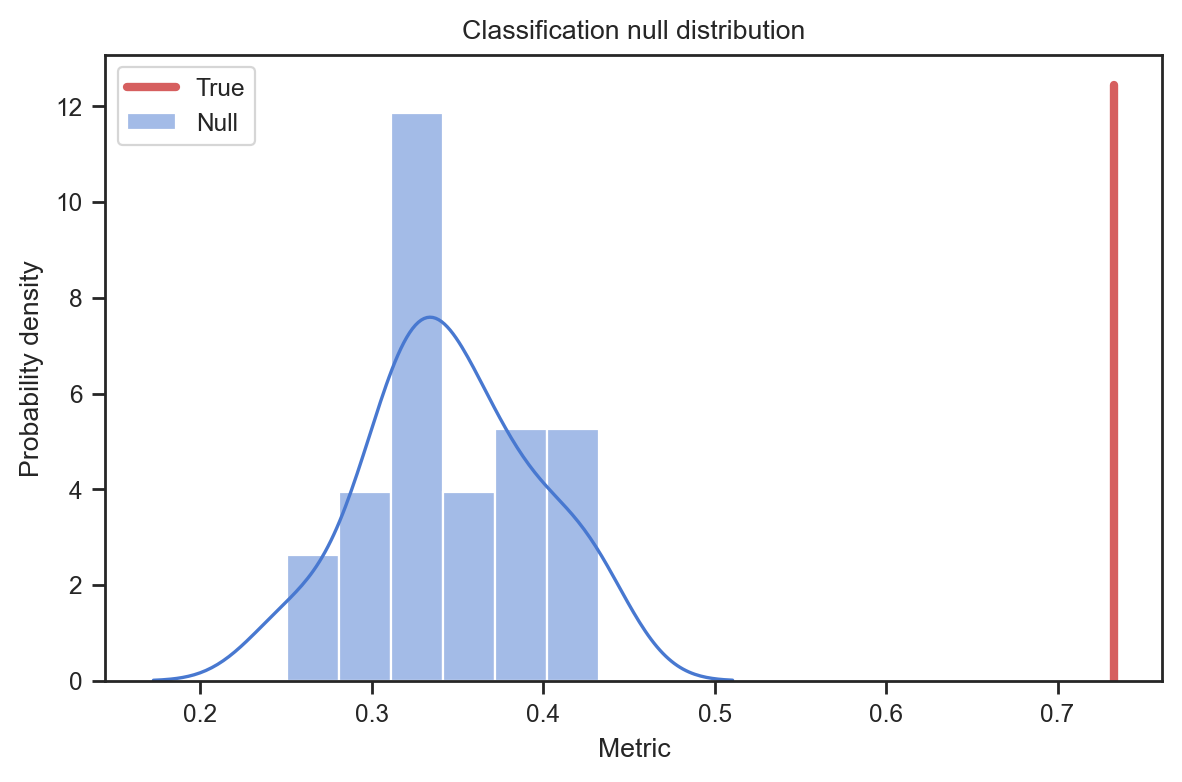

In [14]:
null_predictions = gclass.compute_null_predictions(
    data, labels, classifier, parameters,
    confounds=confounds, n_perms=25
)
metrics = gclass.evaluate_significance(null_predictions)
gvis.visualise_null_metrics(metrics)

### Classifier interpretation

We also want to know how a classifier is able to distinguish classes. To do this, we use the [`shap`](https://github.com/slundberg/shap) package. This gives the following summary of each feature's contribution to the overall prediction:

Generating a classifier explanation...


Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Classifier parameters optimised.
{'clf__C': 100.0}


  0%|          | 0/178 [00:00<?, ?it/s]

SHAP values generated.



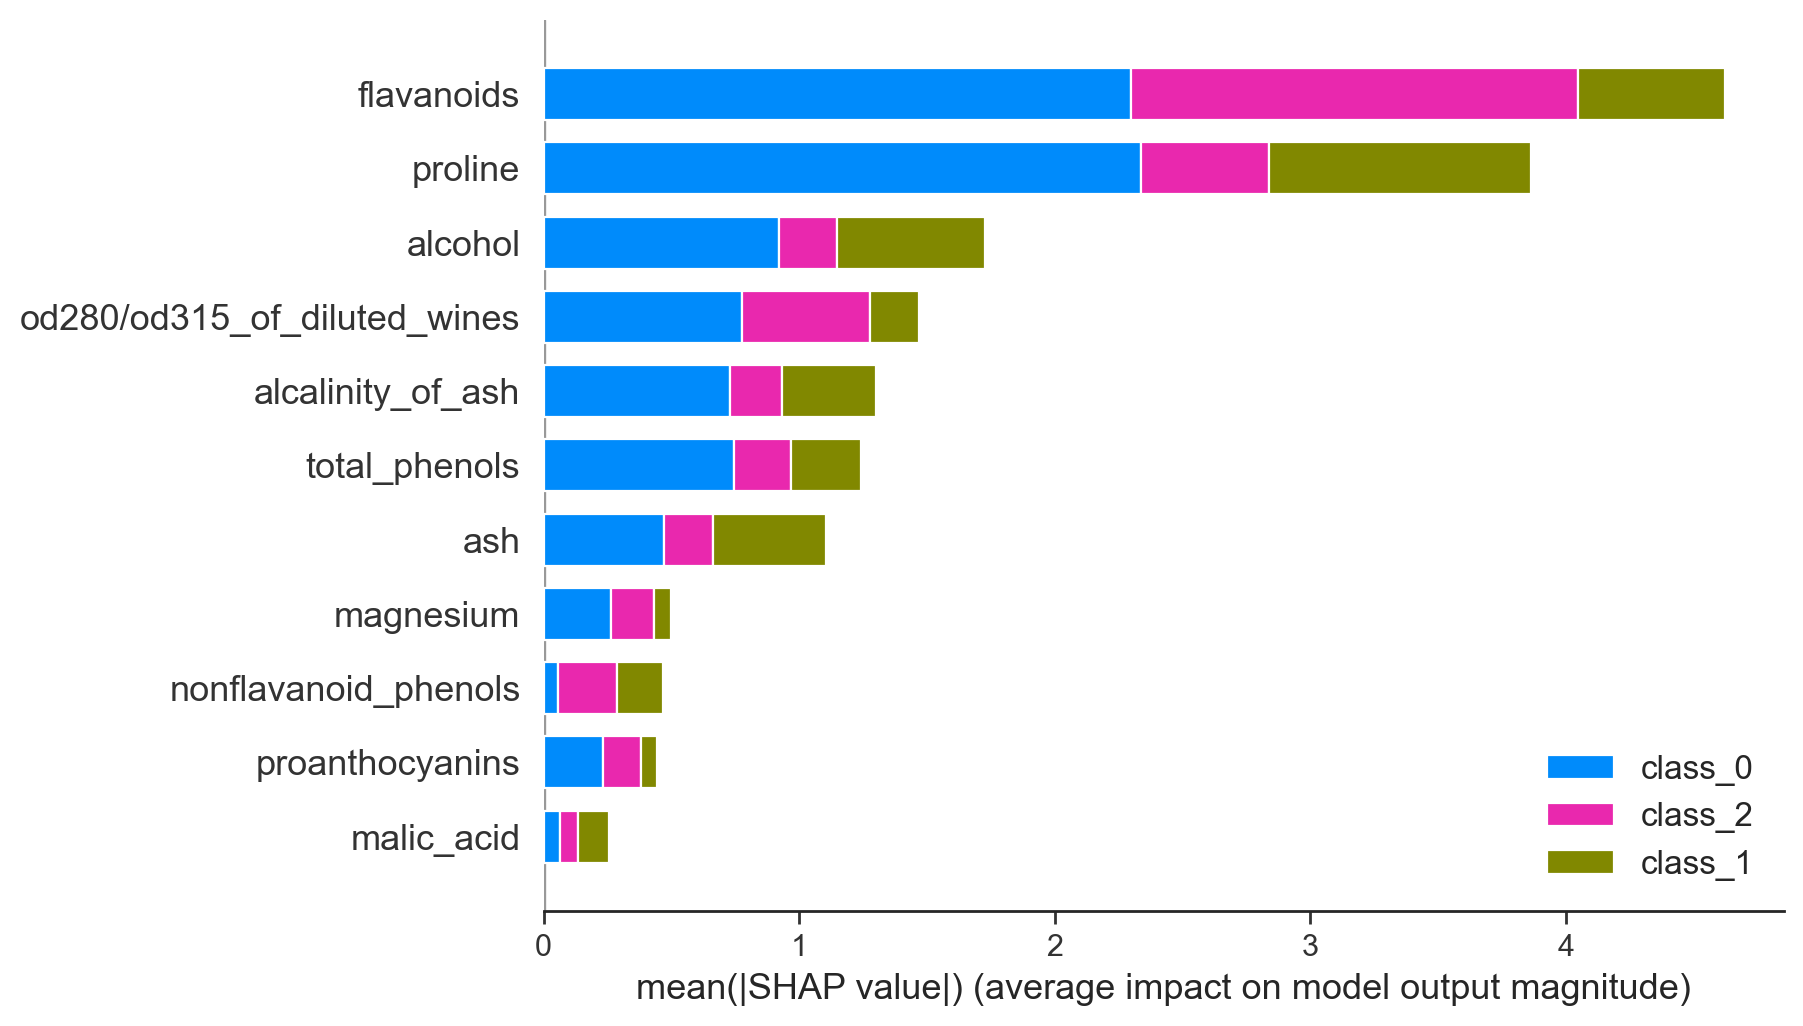

In [15]:
explanation = gclass.explain_classifier(
    data, labels, classifier, parameters,
    confounds=confounds
)
gvis.visualise_explanation(explanation, per_class=False)

-----

### Further tweaks

Finally, we may want to change from the defaults and try e.g. different classifiers / regularisation strategies / feature selection / etc. There are lots of examples in the README of how to do this.

Below, we show a couple of tweaks:
 + We add L1 as well as L2 regularisation, and optimise over a wider range of parameters.
 + However, the variance of the loss in the inner loop is high, so we risk overfitting. We switch to using the negative log loss to pick the best set of parameters as this gives more stability.
 + We use run the outer loop multiple times, using a repeated k-fold approach. The final metrics will therefore be averaged over more train/test splits.

In [16]:
classifier, parameters = gclass.get_default_classifier()
parameters['clf__C'] = np.geomspace(1.0e-2, 1.0e2, 9)
parameters['clf__l1_ratio'] = np.linspace(0.0, 1.0, 6)
cv_iter = sklearn.model_selection.RepeatedKFold(
    n_splits=10, n_repeats=3
)

predictions = gclass.predict(
    data, labels, classifier, parameters,
    confounds=confounds, cv_iter=cv_iter,
    inner_cv_kwargs=dict(
        n_splits=5, n_repeats=5, scoring='neg_log_loss'
    )
)
gclass.evaluate_performance(labels, predictions)

Classifying data...
No. of features: 11
No. of observations: 178
No. of confounds: 2
No. of classes: 3
Classes: class_0, class_1, class_2

Finished iteration 1 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 2 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 3 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 4 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 5 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 6 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 7 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.8}
Finished iteration 8 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.8}
Finished iteration 9 of 30
{'clf__C': 0.31622776601683794, 'clf__l1_ratio': 0.6000000000000001}
Finished iteration 10 of 30